# Импорт библиотек, открытие датасета

In [69]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')



%matplotlib inline

In [28]:
df_train_raw = pd.read_csv('data/train.csv')
df_test_raw = pd.read_csv('data/test.csv')

df_train = df_train_raw.copy(deep = True)
df_test  = df_test_raw.copy(deep = True)

data_cleaner = [df_train_raw, df_test_raw]

# Общий анализ

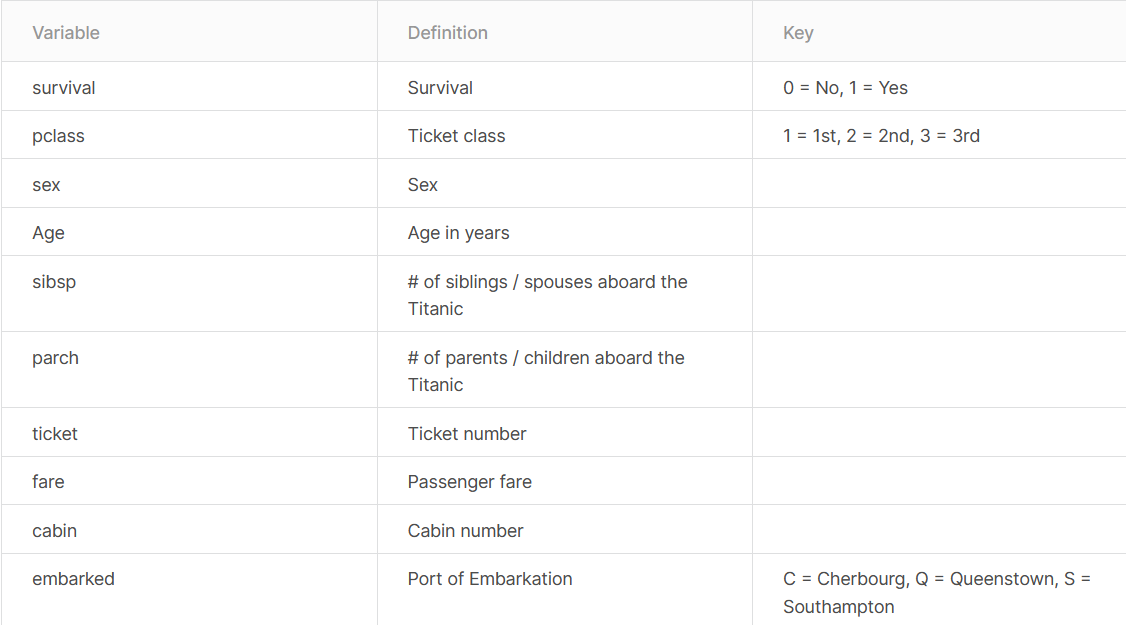

In [29]:
df_train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [30]:
for name in df_train.columns:
    print(name+": ",type(df_train.loc[1,name]))

PassengerId:  <class 'numpy.int64'>
Survived:  <class 'numpy.int64'>
Pclass:  <class 'numpy.int64'>
Name:  <class 'str'>
Sex:  <class 'str'>
Age:  <class 'numpy.float64'>
SibSp:  <class 'numpy.int64'>
Parch:  <class 'numpy.int64'>
Ticket:  <class 'str'>
Fare:  <class 'numpy.float64'>
Cabin:  <class 'str'>
Embarked:  <class 'str'>


In [31]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Важно понимать какие данные пропущены

In [32]:
df_train.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

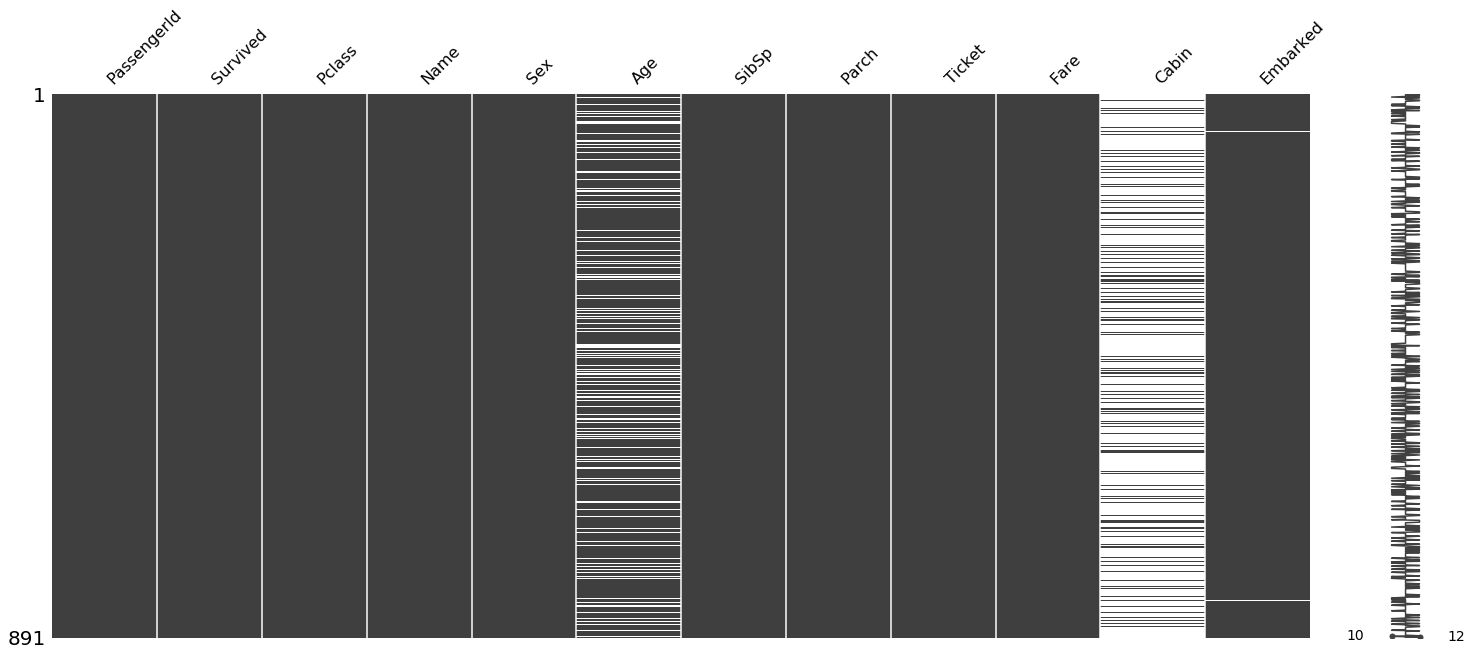

In [33]:
msno.matrix(df_train)

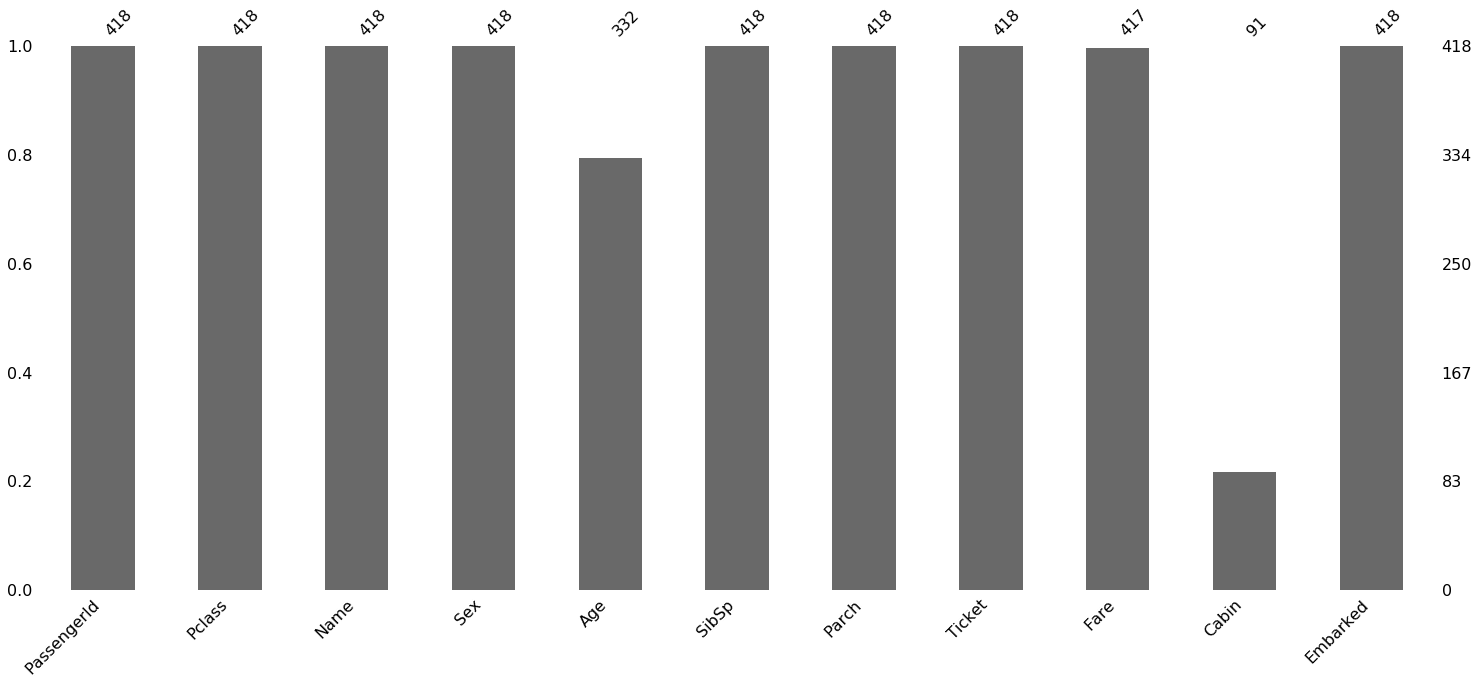

In [34]:
msno.bar(df_test)

# Углубленный анализ

<h2> Корреляция возраста с другими признаками

Прежде чем мы начнем очищать данные, важно увидеть, какие переменные имеют значение, какие можно игнорировать и как лучше всего заполнить недостающие значения. Как мы видим на диаграммах выше, в тренировочном наборе есть 3 переменные с пропущенными значениями (Возраст, Каюта и Посадка) и только 2 в тестовом наборе (Возраст, Каюта). В тестовом наборе также отсутствует 1 запись о тарифе, которую мы заполним позже. Теперь мы попытаемся решить, что мы будем делать с этими значениями.

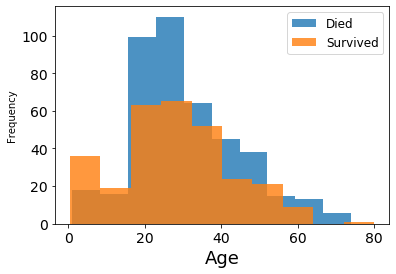

In [35]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.figure()
fig = df_train.groupby('Survived')['Age'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'), fontsize = 12)
plt.xlabel('Age', fontsize = 18)
plt.show()

Мы видим, что распределение по возрасту между теми, кто выжил, и теми, кто не выжил, похоже. Однако мы видим, что большинство пассажиров молодого возраста были спасены. Следовательно, возраст после порогового значения, вероятно, не был основным фактором, определяющим, кто выжил в аварии. Теперь мы исследуем, как заполнить пропущенные века. Несколько стратегий указывают на замену отсутствующих значений средним значением или медианой всего распределения, что, на наш взгляд, не кажется хорошим выбором. Вместо этого давайте посмотрим на корреляцию возраста с другими переменными.

In [36]:
df_train.corr(method='pearson')['Age'].abs()

PassengerId    0.036847
Survived       0.077221
Pclass         0.369226
Age            1.000000
SibSp          0.308247
Parch          0.189119
Fare           0.096067
Name: Age, dtype: float64

Мы видим, что самая сильная корреляция переменной возраста связана с переменной Pclass (пассажирский класс). Поэтому уместно использовать эту информацию для выборки отсутствующих возрастов в соответствии с pclass. Мы можем либо взять медиану каждой группы Pclass, либо выбрать случайное значение из этой группы. Мы собираемся попробовать оба и посмотреть, какой из них дает лучшие результаты. Давайте теперь исследуем влияние количества родственников на борту на выживаемость. Для этого мы создали новую фичу под названием «Family on board». 

<h2>Зависимость выживаемости от кол-ва членов семьи

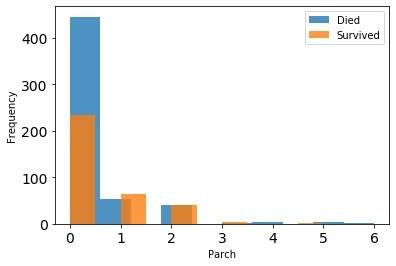

In [37]:
plt.figure()
fig = df_train.groupby('Survived')['Parch'].plot.hist(histtype= 'bar',alpha = 0.8)
plt.legend(('Died','Survived'),)
plt.xlabel('Parch')
plt.show()

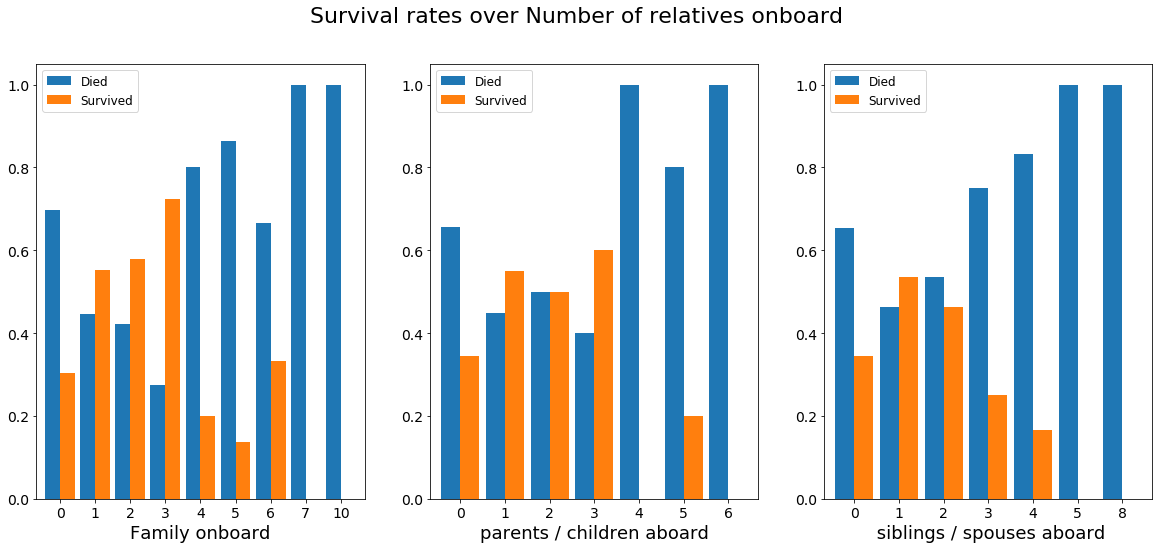

In [38]:
df_train['Family onboard'] = df_train['Parch'] + df_train['SibSp']
plt.rcParams['figure.figsize'] = [20, 8]
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

fig, axes = plt.subplots(nrows=1, ncols=3)
df_train.groupby(['Parch'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[1],width = 0.85)
df_train.groupby(['SibSp'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[2],width = 0.85)
df_train.groupby(['Family onboard'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[0],width = 0.85)

axes[0].set_xlabel('Family onboard',fontsize = 18)
axes[1].set_xlabel('parents / children aboard',fontsize = 18)
axes[2].set_xlabel(' siblings / spouses aboard',fontsize = 18)

for i in range(3):
    axes[i].legend(('Died','Survived'),fontsize = 12, loc = 'upper left')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)

plt.suptitle('Survival rates over Number of relatives onboard',fontsize =22)
plt.show()

<h2> Зависимость выживаемости от пола

<Figure size 432x360 with 0 Axes>

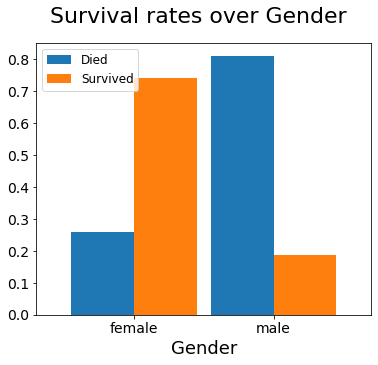

In [39]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.figure()
fig = df_train.groupby(['Sex'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Gender',fontsize =18)
plt.xticks(rotation=0)

plt.suptitle('Survival rates over Gender',fontsize =22)
plt.show()

Мы видим четкую тенденцию, что чем меньше родственников на борту, тем выше шанс выжить. Поэтому мы заключаем, что это интересная функция для включения в наши обучающие данные. Мы также видим, что пассажиры-женщины имели больше шансов выжить, чем пассажиры-мужчины. Ожидалось, что у женщин и детей будет больше шансов выжить, поскольку протокол эвакуации с корабля гласил об этом. Теперь сравним шансы на выживание и стоимость билетов пассажиров.

<h2> Зависимость выживаемости от стоимости билетов

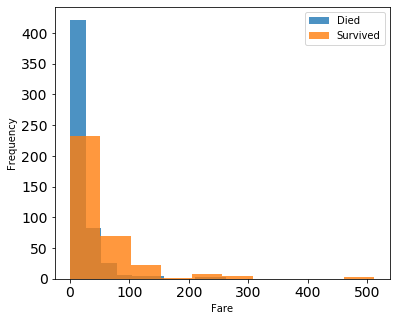

In [40]:
plt.figure()
fig = df_train.groupby('Survived')['Fare'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'))
plt.xlabel('Fare')
plt.show()

plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

Теперь мы хотели бы проверить, может ли титульное имя человека быть полезным для определения того, выжил ли этот человек или нет. Это предположение проистекает из идеи, что люди с более высоким статусом могли иметь более высокий приоритет во время эвакуации с корабля. Поэтому мы создаем новую переменную с именем «Title».

<h2> Зависимость выживаемости от титула

In [41]:
df_train['Title'] = df_train['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip() 
df_test['Title'] = df_test['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()

Некоторые из этих названий можно сгруппировать, поскольку они означают одно и то же. Например, «Миссис», «Мисс», «Мисс» будут сгруппированы вместе под меткой «Миссис». Есть также некоторые титулы, которые на самом деле представляют собой имя, а не титул (Mlle, Mme), которые также будут сопоставлены с тем же значением. «Дон», вероятно, является аббревиатурой мужского имени и будет отображаться как «мистер». Другие категории титулов: «Благородный», «Мастер», «Доктор / духовенство» и «Военный».

In [42]:
def new_titles(df):
    new_titles = dict()
    assert 'Title' in df.columns
    for key in df['Title'].unique():
        females = ['Mrs','Miss','Ms','Mlle','Mme','Dona']
        males = ['Mr','Don']
        notable = ['Jonkheer','the Countess','Lady','Sir','Major','Col','Capt','Dr','Rev','Notable']
        titles = [females,males,notable,'Master']
        newtitles = ['Mrs','Mr','Notable','Master']
        idx = [key in sublist for sublist in titles]
        idx = np.where(idx)[0] 
        new_titles[key] = newtitles[idx[0]]
    return new_titles


new_titles_dict = new_titles(df_train)
df_train['Title'] = df_train['Title'].replace(new_titles_dict)

<Figure size 864x360 with 0 Axes>

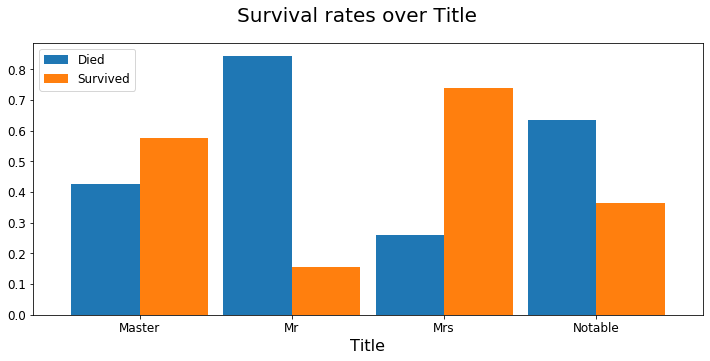

In [43]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

plt.figure()
fig = df_train.groupby(['Title'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Title',fontsize =16)
plt.xticks(rotation=0)


plt.suptitle('Survival rates over Title',fontsize =20)
plt.show()

<h2> Зависимость выживаемости от кабинки

In [44]:
df_train['Cabin'][df_train['Cabin'].isnull()]='Missing'
df_train['Cabin'] = df_train['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]

<Figure size 864x360 with 0 Axes>

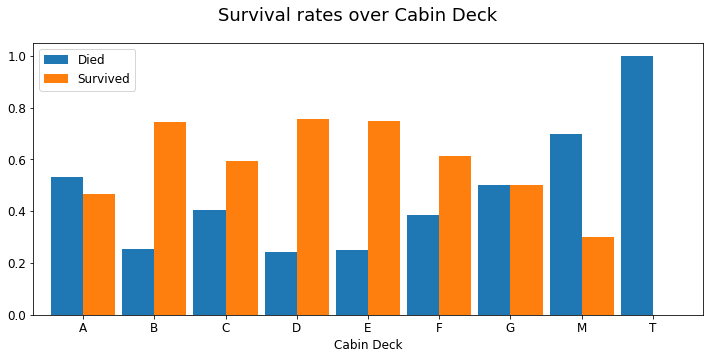

In [45]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.figure()
fig = df_train.groupby(['Cabin'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Cabin Deck',fontsize =12)
plt.suptitle('Survival rates over Cabin Deck',fontsize =18)
plt.xticks(rotation=0)
plt.show()

# Заполнение пропусков

In [46]:
def df_fill(datasets, mode):
    assert mode =='median' or mode =='sampling'
    datasets_cp =[]
    np.random.seed(2)
    varnames = ['Age','Fare']
    for d in datasets:
        df = d.copy(deep = True)
        for var in varnames:
            idx = df[var].isnull()
            if idx.sum()>0:
                if mode =='median':
                    medians = df.groupby('Pclass')[var].median()
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = medians[df['Pclass'][i]]
                else:
                    g = df[idx==False].groupby('Pclass')[var]
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())
    #Embarked                 
        idx = df['Embarked'].isnull()
        g = df[idx==False].groupby('Pclass')['Embarked']
        for i,v in enumerate(idx):
            if v:
                df['Embarked'][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())                   
    #Cabin
        df['Cabin'][df['Cabin'].isnull()]='Missing'
        df['Cabin'] = df['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]
        datasets_cp.append(df)
    return datasets_cp

data_clean = df_fill(data_cleaner,'median')

In [47]:
def prepare_data(datasets):
        datasets_cp = []
        for d in datasets:
            df = d.copy(deep = True)
            df['Family onboard'] = df['Parch'] + df['SibSp']
            df['Title'] = df['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
            new_titles_dict = new_titles(df)
            df['Title'] = df['Title'].replace(new_titles_dict)
            df.drop(columns = ['PassengerId','Name','Ticket'],axis = 1, inplace = True)
            datasets_cp.append(df)
        return datasets_cp
        

In [48]:
train,test = prepare_data(df_fill(data_cleaner,mode = 'sampling'))  
print("Training data")
print(train.isnull().sum())
print("Test data")
print(test.isnull().sum())

Training data
Survived          0
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          0
Family onboard    0
Title             0
dtype: int64
Test data
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          0
Family onboard    0
Title             0
dtype: int64


# Создание модели

<h2> Preproccesing

In [50]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family onboard,Title
0,0,3,male,22.0,1,0,7.2500,M,S,1,Mr
1,1,1,female,38.0,1,0,71.2833,C,C,1,Mrs
2,1,3,female,26.0,0,0,7.9250,M,S,0,Mrs
3,1,1,female,35.0,1,0,53.1000,C,S,1,Mrs
4,0,3,male,35.0,0,0,8.0500,M,S,0,Mr


In [55]:
embark = pd.get_dummies(train['Embarked'])
sex = pd.get_dummies(train['Sex'])
cabin = pd.get_dummies(train['Cabin'])
title = pd.get_dummies(train['Title'])

In [56]:
embark_test = pd.get_dummies(test['Embarked'])
sex_test = pd.get_dummies(test['Sex'])
cabin_test = pd.get_dummies(test['Cabin'])
title_test = pd.get_dummies(test['Title'])

In [ ]:
train.drop(['Sex','Embarked','SibSp','Parch','Cabin','Title'],axis=1,inplace=True)
test.drop(['Sex','Embarked','SibSp','Parch','Cabin','Title'],axis=1,inplace=True)

In [58]:
train = pd.concat([train,sex,embark,cabin,title],axis=1)
test = pd.concat([test, sex, embark, cabin, title],axis=1)

In [61]:
sc = StandardScaler()

In [62]:
train['Age'] = [i[0] for i in sc.fit_transform([[i] for i in train['Age']])]
train['Fare'] = [i[0] for i in sc.fit_transform([[i] for i in train['Fare']])]

In [63]:
train.head()

,Survived,Pclass,Age,Fare,Family onboard,female,male,C,Q,S,...,D,E,F,G,M,T,Master,Mr,Mrs,Notable
0,0,3,-0.530835,-0.502445,1,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,1,1,0.576197,0.786845,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,3,-0.254077,-0.488854,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0.368628,0.420730,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,3,0.368628,-0.486337,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0


# Model

In [70]:
def cross_metrics(model, X_train, y_train):
    scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted']
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=3)
    sorted(scores.keys())
    LR_fit_time = scores['fit_time'].mean()
    LR_score_time = scores['score_time'].mean()
    LR_accuracy = scores['test_accuracy'].mean()
    LR_precision = scores['test_precision_macro'].mean()
    LR_recall = scores['test_recall_macro'].mean()
    LR_f1 = scores['test_f1_weighted'].mean()
    
    print("fit_time: ",LR_fit_time)
    print("score time: ",LR_score_time)
    print("test_accuracy: ",LR_accuracy)
    print("test_precision_macro: ",LR_precision)
    print("test_recall_macro: ",LR_recall)
    print("test_f1_weighted: ",LR_f1)

In [71]:
lr = LogisticRegression()

In [72]:
lr.fit(train.drop(columns=['Survived'],inplace=False),train['Survived'])

LogisticRegression()

In [73]:
cross_metrics(lr, train.drop(columns=['Survived'],inplace=False),train['Survived'])

fit_time:  0.03833230336507162
score time:  0.006667534510294597
test_accuracy:  0.8215488215488215
test_precision_macro:  0.8146462916226702
test_recall_macro:  0.806682005560349
test_f1_weighted:  0.8205364908222427


# REQUESTS

In [74]:
import requests as re

In [75]:
data = re.get('https://napi.wildberries.ru/api/catalog/15951482/detail.aspx?targetUrl=MS',
              headers={'Wb-AppType':'android'})

In [80]:
data.json()['data']['productInfo']['brandName']

'Индивид'